In [1]:
#!pip install lime
#!pip install shap
#!pip install imblearn

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as s
import matplotlib.pyplot as plt
sns.set(style = 'whitegrid')
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report

from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from sklearn.metrics import confusion_matrix,precision_score,f1_score,cohen_kappa_score,accuracy_score

from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,roc_auc_score,roc_curve

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,StackingClassifier

from xgboost import XGBClassifier

import pydotplus

from IPython.display import Image

import os
os.environ["PATH"] += os.pathsep + 'C:\Users\Lenovo\anaconda3\Library\bin'

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, cross_val_score

import lime
from lime import lime_tabular

import shap

from statsmodels.stats.outliers_influence import variance_inflation_factor

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-100-0a331373eb6e>, line 34)

1. **[Decision Tree](#dtree)**

### Reading the data

In [3]:
data = pd.read_excel('Store_Data_after_EDA.xlsx')

data = data.drop(columns=['Unnamed: 0', 'index'],axis=1)
data.head()

custid  retained    created           firstorder            lastorder  \
0  6H6T6N         0 2012-09-28  2013-08-11 00:00:00  2013-08-11 00:00:00   
1  APCENR         1 2010-12-19  2011-04-01 00:00:00  2014-01-19 00:00:00   
2  7UP6MS         0 2010-10-03  2010-12-01 00:00:00  2011-07-06 00:00:00   
3  7ZEW8G         0 2010-10-22  2011-03-28 00:00:00  2011-03-28 00:00:00   
4  8V726M         1 2010-11-27  2010-11-29 00:00:00  2013-01-28 00:00:00   

   esent   eopenrate  eclickrate  avgorder   ordfreq  paperless  refill  \
0     29  100.000000    3.448276     14.52  0.000000          0       0   
1     95   92.631579   10.526316     83.69  0.181641          1       1   
2      0    0.000000    0.000000     33.58  0.059908          0       0   
3      0    0.000000    0.000000     54.96  0.000000          0       0   
4     30   90.000000   13.333333    111.91  0.008850          0       0   

   doorstep     favday city  
0         0     Monday  DEL  
1         1     Friday  DEL  
2         0  Wednesday  DEL  
3         0   Thursday  BOM  
4         0     Monday  BOM

In [4]:
data.retained.value_counts().plot(kind='bar')
plt.show()

In [5]:
# The data is imbalanced.

### Changing the columns into datetime

In [6]:
data['firstorder']= data.firstorder.astype('datetime64')
data['lastorder'] = data.lastorder.astype('datetime64')

### Data information

In [7]:
data.describe()

retained         esent     eopenrate    eclickrate      avgorder  \
count  30781.000000  30781.000000  30781.000000  30781.000000  30781.000000   
mean       0.794581     28.136708     25.555884      5.672685     61.840438   
std        0.404014     16.749906     29.556042     10.563981     40.941429   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000     16.000000      2.083333      0.000000     40.020000   
50%        1.000000     32.000000     13.207547      0.000000     50.960000   
75%        1.000000     42.000000     40.000000      7.142857     74.250000   
max        1.000000    291.000000    100.000000    100.000000   2600.140000   

            ordfreq     paperless        refill      doorstep  
count  30781.000000  30781.000000  30781.000000  30781.000000  
mean       0.037753      0.649102      0.095059      0.038920  
std        0.103961      0.477259      0.293301      0.193408  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      1.000000      0.000000      0.000000  
75%        0.040816      1.000000      0.000000      0.000000  
max        3.250000      1.000000      1.000000      1.000000

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30781 entries, 0 to 30780
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   custid      30781 non-null  object        
 1   retained    30781 non-null  int64         
 2   created     30781 non-null  datetime64[ns]
 3   firstorder  30781 non-null  datetime64[ns]
 4   lastorder   30781 non-null  datetime64[ns]
 5   esent       30781 non-null  int64         
 6   eopenrate   30781 non-null  float64       
 7   eclickrate  30781 non-null  float64       
 8   avgorder    30781 non-null  float64       
 9   ordfreq     30781 non-null  float64       
 10  paperless   30781 non-null  int64         
 11  refill      30781 non-null  int64         
 12  doorstep    30781 non-null  int64         
 13  favday      30781 non-null  object        
 14  city        30781 non-null  object        
dtypes: datetime64[ns](3), float64(4), int64(5), object(3)
memory usage: 3.

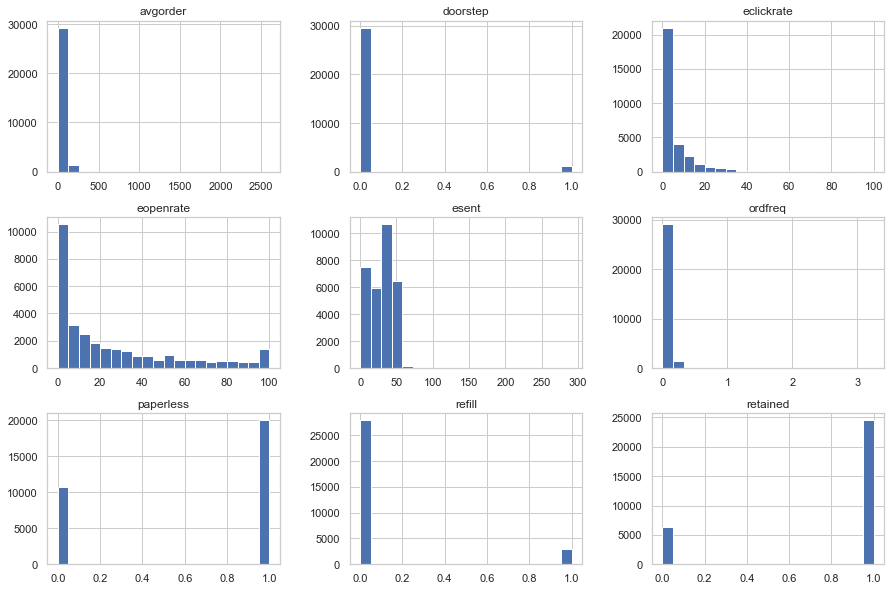

In [9]:
data.hist(bins=20,figsize=(15,10))
plt.show()

In [10]:
data['create_first'] = data.firstorder - data.created
data['create_first'] = data['create_first']/np.timedelta64(1,'D')
data['first_last'] = data.lastorder - data.firstorder
data['first_last'] = data['first_last']/np.timedelta64(1,'D')

In [11]:
data.describe()

retained         esent     eopenrate    eclickrate      avgorder  \
count  30781.000000  30781.000000  30781.000000  30781.000000  30781.000000   
mean       0.794581     28.136708     25.555884      5.672685     61.840438   
std        0.404014     16.749906     29.556042     10.563981     40.941429   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000     16.000000      2.083333      0.000000     40.020000   
50%        1.000000     32.000000     13.207547      0.000000     50.960000   
75%        1.000000     42.000000     40.000000      7.142857     74.250000   
max        1.000000    291.000000    100.000000    100.000000   2600.140000   

            ordfreq     paperless        refill      doorstep  create_first  \
count  30781.000000  30781.000000  30781.000000  30781.000000  30781.000000   
mean       0.037753      0.649102      0.095059      0.038920     41.345570   
std        0.103961      0.477259      0.293301      0.193408    127.208724   
min        0.000000      0.000000      0.000000      0.000000    -39.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      1.000000   
75%        0.040816      1.000000      0.000000      0.000000     22.000000   
max        3.250000      1.000000      1.000000      1.000000   1998.000000   

         first_last  
count  30781.000000  
mean      90.870277  
std      224.732949  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max     2480.000000

In [12]:
data = data.drop(['ordfreq','custid'],axis=1)

In [13]:
data = data.drop(['firstorder','lastorder','created'],axis=1)

In [14]:
data.head()

retained  esent   eopenrate  eclickrate  avgorder  paperless  refill  \
0         0     29  100.000000    3.448276     14.52          0       0   
1         1     95   92.631579   10.526316     83.69          1       1   
2         0      0    0.000000    0.000000     33.58          0       0   
3         0      0    0.000000    0.000000     54.96          0       0   
4         1     30   90.000000   13.333333    111.91          0       0   

   doorstep     favday city  create_first  first_last  
0         0     Monday  DEL         317.0         0.0  
1         1     Friday  DEL         103.0      1024.0  
2         0  Wednesday  DEL          59.0       217.0  
3         0   Thursday  BOM         157.0         0.0  
4         0     Monday  BOM           2.0       791.0

### Test-Train Split

In [15]:
inp = data.drop('retained',axis=1)
out = data.retained
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(inp,out,test_size=0.3,random_state=12)

### Outlier Treatment

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.kdeplot(xtrain.esent,color='red');
plt.subplot(2,3,2)
sns.kdeplot(data.eclickrate,color='green')
plt.subplot(2,3,3)
sns.kdeplot(data.avgorder,color='black')
plt.subplot(2,3,4)
sns.kdeplot(data.eopenrate,color='blue')
plt.show()

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.boxplot(x = data.esent,color='red');
plt.subplot(2,3,2)
sns.boxplot(x = data.eclickrate,color='green')
plt.subplot(2,3,3)
sns.boxplot(x = data.avgorder,color='pink')
plt.subplot(2,3,4)
sns.boxplot(data.eopenrate,color='blue')
plt.show()

In [18]:
def impute(x):
    for i in x.columns:
        iqr = 1.5*(x[i].quantile(0.75) - x[i].quantile(0.25))
        ul = x[i].quantile(0.75) + iqr
        ll = x[i].quantile(0.25) - iqr
        temp = []
        for j in x[i].index:
            if x[i][j] > ul or x[i][j] < ll :
                temp.append(np.median(x[i]))
            elif x[i][j] < 0:
                temp.append(0)
            else:
                temp.append(x[i][j])
        x[i]= temp
    return x

In [19]:
xtrain[['esent','eclickrate','avgorder','eopenrate']] = impute(xtrain[['esent','eclickrate','avgorder','eopenrate']])
xtest[['esent','eclickrate','avgorder','eopenrate']] = impute(xtest[['esent','eclickrate','avgorder','eopenrate']])

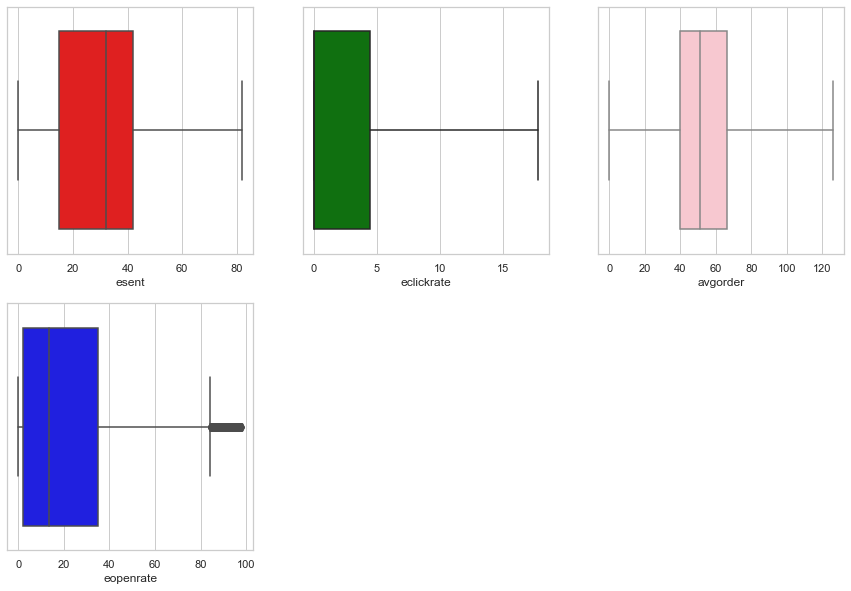

In [20]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.boxplot(x = xtrain.esent,color='red');
plt.subplot(2,3,2)
sns.boxplot(x = xtrain.eclickrate,color='green',whis=6)
plt.subplot(2,3,3)
sns.boxplot(x = xtrain.avgorder,color='pink',whis=3)
plt.subplot(2,3,4)
sns.boxplot(xtrain.eopenrate,color='blue')
plt.show()

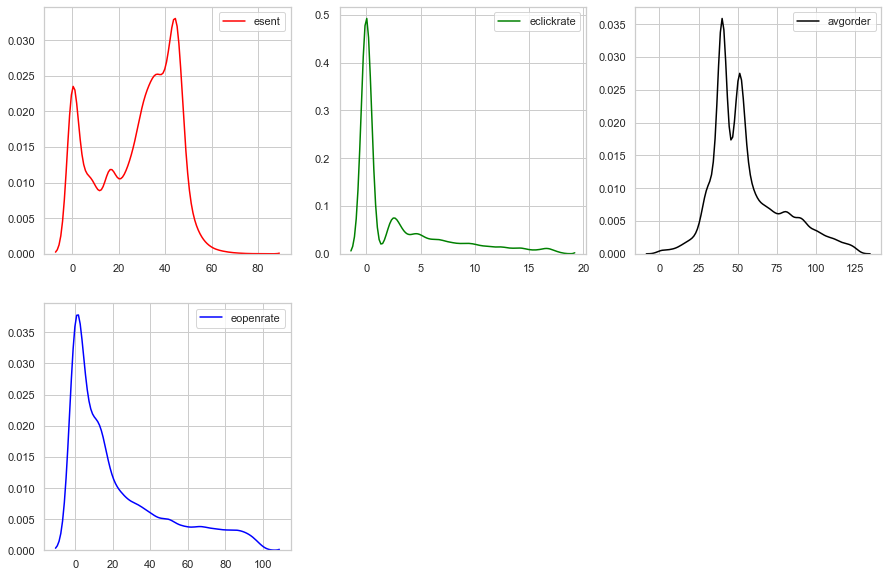

In [21]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.kdeplot(xtrain.esent,color='red');
plt.subplot(2,3,2)
sns.kdeplot(xtrain.eclickrate,color='green')
plt.subplot(2,3,3)
sns.kdeplot(xtrain.avgorder,color='black')
#plt.subplot(2,3,4)
#sns.kdeplot(xtrain.ordfreq,color='orange')
plt.subplot(2,3,4)
sns.kdeplot(xtrain.eopenrate,color='blue')
plt.show()

In [22]:
xtrain.describe()

esent     eopenrate    eclickrate      avgorder     paperless  \
count  21546.000000  21546.000000  21546.000000  21546.000000  21546.000000   
mean      27.991646     22.610320      2.783496     54.945846      0.649355   
std       16.528547     25.907751      4.313310     22.619779      0.477183   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       15.000000      2.127660      0.000000     40.020000      0.000000   
50%       32.000000     13.333333      0.000000     50.940000      1.000000   
75%       42.000000     35.000000      4.444444     66.195000      1.000000   
max       82.000000     98.305085     17.777778    126.020000      1.000000   

             refill      doorstep  create_first    first_last  
count  21546.000000  21546.000000  21546.000000  21546.000000  
mean       0.094681      0.037548     41.552121     92.060847  
std        0.292781      0.190104    127.696748    227.521154  
min        0.000000      0.000000    -39.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      1.000000      0.000000  
75%        0.000000      0.000000     22.000000     46.000000  
max        1.000000      1.000000   1998.000000   2480.000000

## Data Visualization

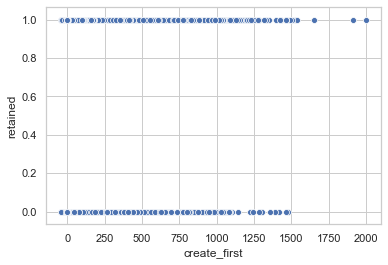

In [23]:
sns.scatterplot(x = data.create_first, y = data.retained)

In [24]:
sns.scatterplot(x = data.first_last, y = data.retained)

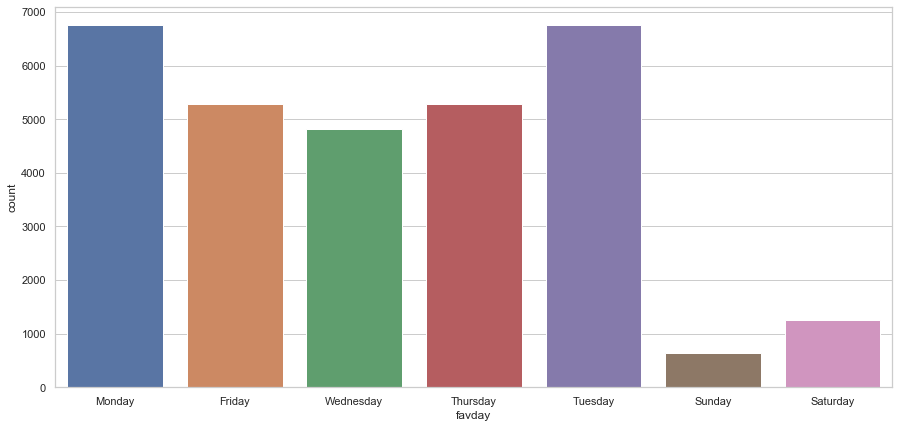

In [25]:
plt.figure(figsize=(15,7))
sns.countplot(x = data.favday)
plt.show()

In [26]:
pd.crosstab(index=data.city,columns=data.retained).plot(kind='bar',figsize=(15,8))

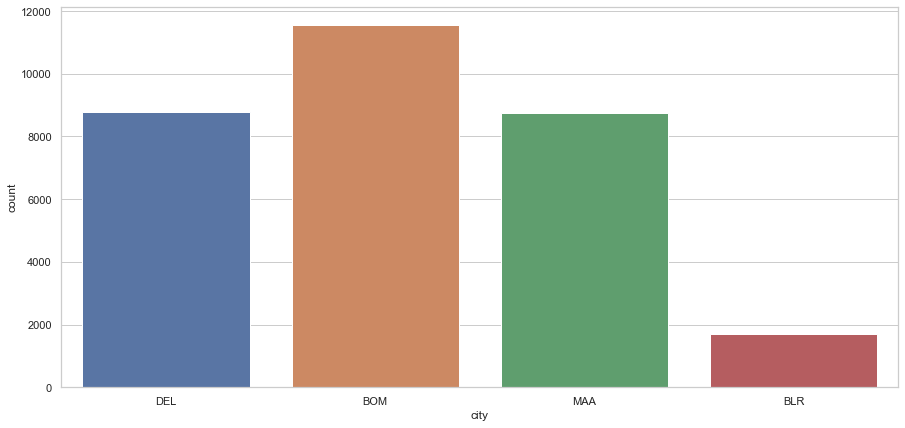

In [27]:
plt.figure(figsize=(15,7))
sns.countplot(x = data.city)
plt.show()

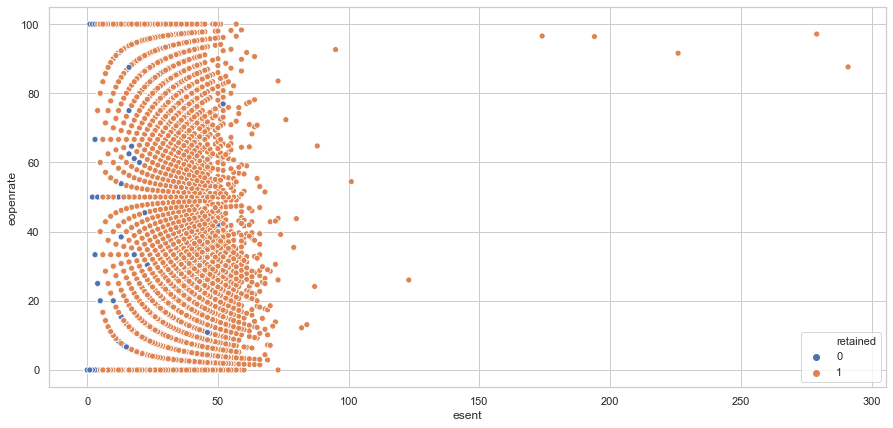

In [28]:
plt.figure(figsize=(15,7))
sns.scatterplot(x= data.esent, y = data.eopenrate, hue= data.retained)
plt.show()

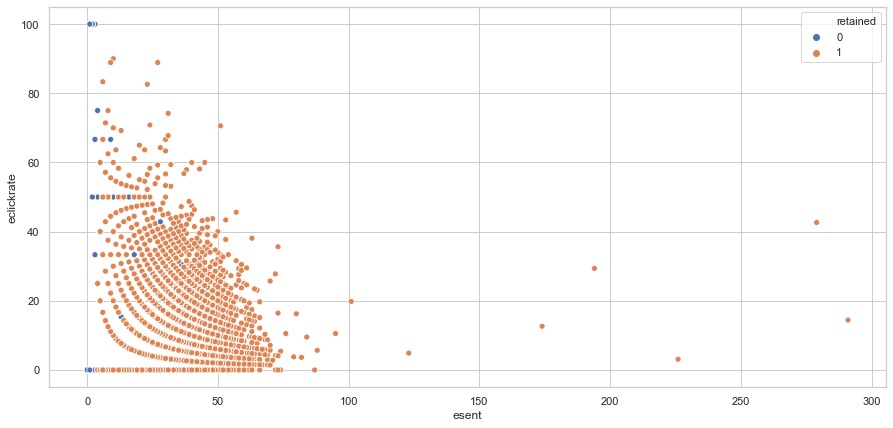

In [29]:
plt.figure(figsize=(15,7))
sns.scatterplot(x= data.esent, y = data.eclickrate, hue= data.retained)
plt.show()

In [30]:
plt.figure(figsize=(15,7))
sns.scatterplot(x= data.eclickrate, y = data.eopenrate, hue= data.retained)
plt.show()

In [31]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),annot=True,annot_kws={'size':20}, cmap = 'gist_earth');

In [32]:
xtrain.head()

esent  eopenrate  eclickrate  avgorder  paperless  refill  doorstep  \
26377    0.0   0.000000    0.000000     50.72          0       0         0   
12904   45.0   4.444444    2.222222     74.76          1       0         0   
19672   27.0  85.185185   14.814815     55.07          1       1         0   
18241   34.0   0.000000    0.000000     46.17          1       0         0   
2056    55.0  18.181818    1.818182     50.94          1       0         0   

          favday city  create_first  first_last  
26377    Tuesday  DEL           0.0       708.0  
12904     Friday  MAA          52.0         0.0  
19672  Wednesday  BOM           0.0         0.0  
18241    Tuesday  MAA          17.0         0.0  
2056      Monday  DEL         179.0      1049.0

In [33]:
xtest.head()

esent  eopenrate  eclickrate  avgorder  paperless  refill  doorstep  \
23814      9   0.000000    0.000000     31.02          1       0         0   
16885     40   7.500000    5.000000     68.88          1       0         0   
28714     37   0.000000    0.000000     40.02          1       0         0   
3392      43   6.976744    0.000000      7.70          0       0         0   
1764      46   2.173913    2.173913     87.50          0       0         0   

          favday city  create_first  first_last  
23814     Monday  DEL           0.0         0.0  
16885     Monday  MAA          29.0         0.0  
28714  Wednesday  BOM           5.0         0.0  
3392    Thursday  BOM           0.0         0.0  
1764     Tuesday  BLR           0.0        30.0

## Transformation

In [34]:
xtrain['avgorder'] = s.boxcox(xtrain.avgorder+1)[0]
xtrain['esent'] = s.boxcox(xtrain.esent+1)[0]
xtrain['eopenrate'] = s.boxcox(xtrain.eopenrate+1)[0]
xtrain['eclickrate'] = s.boxcox(xtrain.eclickrate+1)[0]
xtrain['create_first'] = s.boxcox(abs(xtrain.create_first)+1)[0]
xtrain['first_last'] = s.boxcox(xtrain.first_last+5)[0]

In [35]:
xtrain.head()

esent  eopenrate  eclickrate   avgorder  paperless  refill  \
26377   0.000000   0.000000    0.000000  10.050001          0       0   
12904  28.737037   1.927733    0.788593  12.201272          1       0   
19672  18.503292   6.326022    1.192450  10.476954          1       1   
18241  22.578927   0.000000    0.000000   9.580403          1       0   
2056   34.135013   3.710895    0.728382  10.072085          1       0   

       doorstep     favday city  create_first  first_last  
26377         0    Tuesday  DEL      0.000000    1.652906  
12904         0     Friday  MAA      2.336064    1.037257  
19672         0  Wednesday  BOM      0.000000    1.037257  
18241         0    Tuesday  MAA      1.942901    1.037257  
2056          0     Monday  DEL      2.653102    1.660014

In [36]:
xtest['avgorder'] = s.boxcox(xtest.avgorder+1)[0]
xtest['esent'] = s.boxcox(xtest.esent+1)[0]
xtest['eopenrate'] = s.boxcox(xtest.eopenrate+1)[0]
xtest['eclickrate'] = s.boxcox(xtest.eclickrate+1)[0]
xtest['create_first'] = s.boxcox(abs(xtest.create_first)+1)[0]
xtest['first_last'] = s.boxcox(xtest.first_last+5)[0]

In [37]:
xtest.head()

esent  eopenrate  eclickrate   avgorder  paperless  refill  \
23814   7.332319   0.000000    0.000000   8.233302          1       0   
16885  27.665769   2.479603    0.982111  12.569997          1       0   
28714  25.829369   0.000000    0.000000   9.450932          1       0   
3392   29.484299   2.395254    0.000000   3.630310          0       0   
1764   31.286335   1.249433    0.770719  14.207098          0       0   

       doorstep     favday city  create_first  first_last  
23814         0     Monday  DEL      0.000000    1.026465  
16885         0     Monday  MAA      2.115218    1.026465  
28714         0  Wednesday  BOM      1.379811    1.026465  
3392          0   Thursday  BOM      0.000000    1.026465  
1764          0    Tuesday  BLR      0.000000    1.455169

In [38]:
xtest.describe()

esent    eopenrate   eclickrate     avgorder    paperless  \
count  9235.000000  9235.000000  9235.000000  9235.000000  9235.000000   
mean     19.850333     2.818226     0.396382    10.911535     0.648511   
std      11.009007     2.041551     0.489902     2.351381     0.477461   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      12.286070     0.000000     0.000000     9.450932     0.000000   
50%      23.350213     3.115985     0.000000    10.749145     1.000000   
75%      28.880018     4.526993     0.951031    12.249096     1.000000   
max      50.835025     6.319732     1.177551    16.968334     1.000000   

            refill     doorstep  create_first   first_last  
count  9235.000000  9235.000000   9235.000000  9235.000000  
mean      0.095939     0.042122      1.011319     1.210015  
std       0.294524     0.200879      1.032344     0.243740  
min       0.000000     0.000000      0.000000     1.026465  
25%       0.000000     0.000000      0.000000     1.026465  
50%       0.000000     0.000000      0.624672     1.026465  
75%       0.000000     0.000000      2.048889     1.490188  
max       1.000000     1.000000      2.924602     1.628205

In [39]:
xtrain.describe()

esent     eopenrate    eclickrate      avgorder     paperless  \
count  21546.000000  21546.000000  21546.000000  21546.000000  21546.000000   
mean      18.475017      2.974179      0.411344     10.214720      0.649355   
std       10.320500      2.132582      0.503266      2.143288      0.477183   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       11.097454      1.242879      0.000000      8.901619      0.000000   
50%       21.428730      3.268096      0.000000     10.072085      1.000000   
75%       27.083059      4.735864      0.975280     11.487842      1.000000   
max       48.030764      6.604207      1.214238     15.717931      1.000000   

             refill      doorstep  create_first    first_last  
count  21546.000000  21546.000000  21546.000000  21546.000000  
mean       0.094681      0.037548      1.038520      1.231352  
std        0.292781      0.190104      1.049521      0.254853  
min        0.000000      0.000000      0.000000      1.037257  
25%        0.000000      0.000000      0.000000      1.037257  
50%        0.000000      0.000000      0.626707      1.037257  
75%        0.000000      0.000000      2.091091      1.523161  
max        1.000000      1.000000      3.023757      1.670880

## Scaling

In [40]:
SS = StandardScaler()

In [41]:
a = SS.fit_transform(xtrain[['eclickrate','eopenrate','eclickrate','avgorder','esent','create_first','first_last']])

In [42]:
xtrain['eclickrate'] = a[:,0]
xtrain['eopenrate'] = a[:,1]
xtrain['eclickrate'] = a[:,2]
xtrain['avgorder'] = a[:,3]
xtrain['esent'] = a[:,4]
xtrain['create_first'] = a[:,5]
xtrain['first_last'] = a[:,6]

In [43]:
xtrain.head()

esent  eopenrate  eclickrate  avgorder  paperless  refill  doorstep  \
26377 -1.790170  -1.394670   -0.817369 -0.076855          0       0         0   
12904  0.994357  -0.490706    0.749618  0.926893          1       0         0   
19672  0.002740   1.571767    1.552109  0.122354          1       1         0   
18241  0.397656  -1.394670   -0.817369 -0.295962          1       0         0   
2056   1.517403   0.345465    0.629975 -0.066551          1       0         0   

          favday city  create_first  first_last  
26377    Tuesday  DEL     -0.989541    1.654142  
12904     Friday  MAA      1.236349   -0.761611  
19672  Wednesday  BOM     -0.989541   -0.761611  
18241    Tuesday  MAA      0.861728   -0.761611  
2056      Monday  DEL      1.538435    1.682034

In [44]:
b = SS.transform(xtest[['eclickrate','eopenrate','eclickrate','avgorder','esent','create_first','first_last']])
b

array([[-0.81736927, -1.39466998, -0.81736927, ..., -1.07969145,
        -0.98954088, -0.80396105],
       [ 1.134151  , -0.23191942,  1.134151  , ...,  0.89055428,
         1.02591856, -0.80396105],
       [-0.81736927, -1.39466998, -0.81736927, ...,  0.71261308,
         0.32519438, -0.80396105],
       ...,
       [-0.81736927,  0.81521519, -0.81736927, ..., -1.15143763,
        -0.98954088,  1.015649  ],
       [ 1.33633746,  0.14984141,  1.33633746, ...,  0.59294766,
        -0.98954088, -0.80396105],
       [-0.81736927,  1.55983621, -0.81736927, ..., -0.3380164 ,
        -0.98954088, -0.80396105]])

In [45]:
xtest['eclickrate'] = b[:,0]
xtest['eopenrate'] = b[:,1]
xtest['eclickrate'] = b[:,2]
xtest['avgorder'] = b[:,3]
xtest['esent'] = b[:,4]
xtest['create_first'] = b[:,5]
xtest['first_last'] = b[:,6]

In [46]:
xtest.head()

esent  eopenrate  eclickrate  avgorder  paperless  refill  doorstep  \
23814 -1.079691  -1.394670   -0.817369 -0.924498          1       0         0   
16885  0.890554  -0.231919    1.134151  1.098934          1       0         0   
28714  0.712613  -1.394670   -0.817369 -0.356371          1       0         0   
3392   1.066764  -0.271473   -0.817369 -3.072179          0       0         0   
1764   1.241375  -0.808778    0.714102  1.862779          0       0         0   

          favday city  create_first  first_last  
23814     Monday  DEL     -0.989541   -0.803961  
16885     Monday  MAA      1.025919   -0.803961  
28714  Wednesday  BOM      0.325194   -0.803961  
3392    Thursday  BOM     -0.989541   -0.803961  
1764     Tuesday  BLR     -0.989541    0.878238

## One Hot Encoding

In [47]:
xtrain = pd.concat((xtrain.drop(columns=['city','favday'],axis=1),pd.get_dummies(xtrain[['favday','city']],drop_first=True)),
                   axis=1)

In [48]:
xtrain.head()

esent  eopenrate  eclickrate  avgorder  paperless  refill  doorstep  \
26377 -1.790170  -1.394670   -0.817369 -0.076855          0       0         0   
12904  0.994357  -0.490706    0.749618  0.926893          1       0         0   
19672  0.002740   1.571767    1.552109  0.122354          1       1         0   
18241  0.397656  -1.394670   -0.817369 -0.295962          1       0         0   
2056   1.517403   0.345465    0.629975 -0.066551          1       0         0   

       create_first  first_last  favday_Monday  favday_Saturday  \
26377     -0.989541    1.654142              0                0   
12904      1.236349   -0.761611              0                0   
19672     -0.989541   -0.761611              0                0   
18241      0.861728   -0.761611              0                0   
2056       1.538435    1.682034              1                0   

       favday_Sunday  favday_Thursday  favday_Tuesday  favday_Wednesday  \
26377              0                0               1                 0   
12904              0                0               0                 0   
19672              0                0               0                 1   
18241              0                0               1                 0   
2056               0                0               0                 0   

       city_BOM  city_DEL  city_MAA  
26377         0         1         0  
12904         0         0         1  
19672         1         0         0  
18241         0         0         1  
2056          0         1         0

In [49]:
xtest = pd.concat((xtest.drop(columns=['city','favday'],axis=1),pd.get_dummies(xtest[['favday','city']],drop_first=True))
                  ,axis=1)

In [50]:
xtest.head()

esent  eopenrate  eclickrate  avgorder  paperless  refill  doorstep  \
23814 -1.079691  -1.394670   -0.817369 -0.924498          1       0         0   
16885  0.890554  -0.231919    1.134151  1.098934          1       0         0   
28714  0.712613  -1.394670   -0.817369 -0.356371          1       0         0   
3392   1.066764  -0.271473   -0.817369 -3.072179          0       0         0   
1764   1.241375  -0.808778    0.714102  1.862779          0       0         0   

       create_first  first_last  favday_Monday  favday_Saturday  \
23814     -0.989541   -0.803961              1                0   
16885      1.025919   -0.803961              1                0   
28714      0.325194   -0.803961              0                0   
3392      -0.989541   -0.803961              0                0   
1764      -0.989541    0.878238              0                0   

       favday_Sunday  favday_Thursday  favday_Tuesday  favday_Wednesday  \
23814              0                0               0                 0   
16885              0                0               0                 0   
28714              0                0               0                 1   
3392               0                1               0                 0   
1764               0                0               1                 0   

       city_BOM  city_DEL  city_MAA  
23814         0         1         0  
16885         0         0         1  
28714         1         0         0  
3392          1         0         0  
1764          0         0         0

In [51]:
xtrain.to_csv('train.csv')

In [52]:
xtest.to_csv('test.csv')

### Balancing the Data

In [54]:
xtrain.shape

(21546, 18)

In [55]:
ytrain.shape

(21546,)

In [56]:
from imblearn.combine import SMOTEENN

In [57]:
xtrain_bal,ytrain_bal = SMOTEENN().fit_resample(xtrain,ytrain)
xtest_bal,ytest_bal = SMOTEENN().fit_resample(xtest,ytest)

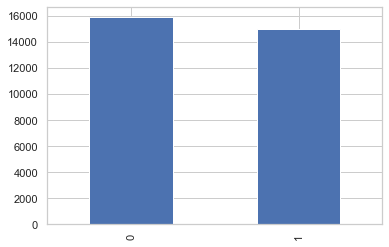

In [59]:
ytrain_bal.value_counts().plot(kind='bar')

## Machine Learning Modelling

#### 1.  LOGISTIC REGRESSION

In [60]:
print(ytest_bal.shape)
print(xtest_bal.shape)
print(xtrain_bal.shape)
print(ytrain_bal.shape)

(13240,)
(13240, 18)
(30914, 18)
(30914,)


#### Full Model

In [61]:
log_reg = sm.Logit(ytrain_bal,xtrain_bal).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.130895
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               retained   No. Observations:                30914
Model:                          Logit   Df Residuals:                    30896
Method:                           MLE   Df Model:                           17
Date:                Thu, 07 Oct 2021   Pseudo R-squ.:                  0.8110
Time:                        14:29:51   Log-Likelihood:                -4046.5
converged:                       True   LL-Null:                       -21415.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
esent                4.1497      0.057     72.971      0.000       4.038       4.261
eopenrate  

In [62]:
odds = pd.DataFrame((np.exp(log_reg.params)),index = xtrain.columns,columns=['ODDS'])
odds

ODDS
esent             63.413235
eopenrate          0.852305
eclickrate         1.039735
avgorder           0.853011
paperless          1.189278
refill             6.945285
doorstep           8.421087
create_first       0.617826
first_last         0.659008
favday_Monday      2.332337
favday_Saturday    6.356904
favday_Sunday      5.470916
favday_Thursday    3.366652
favday_Tuesday     2.037693
favday_Wednesday   3.185230
city_BOM           3.567137
city_DEL           5.899670
city_MAA           3.491463

In [64]:
ypred = log_reg.predict(xtest_bal)
ypred = [1 if i > 0.5 else 0 for i in ypred]

In [65]:
print(classification_report(ytest_bal,ypred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      6868
           1       0.94      0.95      0.95      6372

    accuracy                           0.95     13240
   macro avg       0.95      0.95      0.95     13240
weighted avg       0.95      0.95      0.95     13240



In [66]:
print('Accuracy Score:', round(accuracy_score(ytest_bal,ypred),3))

Accuracy Score: 0.95


In [67]:
cv = cross_val_score(estimator=LogisticRegression(),X=xtest,y=ytest,scoring='accuracy',cv=10)
print('Mean cross validation score:', cv.mean())

Mean cross validation score: 0.943584349922378


## VIF

In [68]:
vif = [variance_inflation_factor(xtrain_bal.values,i) for i in range(xtrain_bal.shape[1])]

In [69]:
vif_df = pd.DataFrame({'Features':xtrain_bal.columns,'VIF':vif})
vif_df.sort_values('VIF',ascending=False)

Features       VIF
4          paperless  2.765840
15          city_BOM  2.629829
16          city_DEL  2.511224
17          city_MAA  2.458516
9      favday_Monday  1.877847
13    favday_Tuesday  1.840708
0              esent  1.772600
1          eopenrate  1.704570
2         eclickrate  1.661608
14  favday_Wednesday  1.646798
12   favday_Thursday  1.611879
11     favday_Sunday  1.195895
5             refill  1.191436
8         first_last  1.177067
7       create_first  1.148128
6           doorstep  1.129965
10   favday_Saturday  1.122954
3           avgorder  1.112693

### Feature Selection

In [70]:
LR = LogisticRegression()

In [71]:
## RFE SElection
rfe = RFE(estimator=LR).fit(xtrain_bal,ytrain_bal)

feature_ranking = pd.DataFrame([xtrain_bal.columns,rfe.ranking_],index=['Feature','Ranking']).T
rfe_feat=feature_ranking[feature_ranking.Ranking==1]
rfe_feat.Feature

0                esent
5               refill
6             doorstep
7         create_first
10     favday_Saturday
11       favday_Sunday
12     favday_Thursday
14    favday_Wednesday
16            city_DEL
Name: Feature, dtype: object

In [72]:
feature_ranking.sort_values('Ranking').reset_index()

index           Feature Ranking
0       0             esent       1
1      14  favday_Wednesday       1
2      12   favday_Thursday       1
3      11     favday_Sunday       1
4      10   favday_Saturday       1
5       5            refill       1
6       6          doorstep       1
7       7      create_first       1
8      16          city_DEL       1
9      17          city_MAA       2
10     15          city_BOM       3
11      8        first_last       4
12      9     favday_Monday       5
13     13    favday_Tuesday       6
14      1         eopenrate       7
15      3          avgorder       8
16      4         paperless       9
17      2        eclickrate      10

In [73]:
x = xtrain_bal[rfe_feat.Feature]
y= ytrain_bal

rfe_reg = sm.Logit(y,x).fit()
print(rfe_reg.summary())

Optimization terminated successfully.
         Current function value: 0.167682
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               retained   No. Observations:                30914
Model:                          Logit   Df Residuals:                    30905
Method:                           MLE   Df Model:                            8
Date:                Thu, 07 Oct 2021   Pseudo R-squ.:                  0.7579
Time:                        14:30:31   Log-Likelihood:                -5183.7
converged:                       True   LL-Null:                       -21415.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
esent                3.6817      0.045     80.922      0.000       3.593       3.771
refill     

Confusion Matrix: [[6590  278]
 [ 500 5872]]


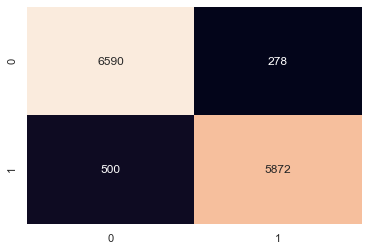

In [76]:
rfe_ypred_test = rfe_reg.predict(xtest_bal[rfe_feat.Feature])
rfe_ypred_test = [1 if i > 0.5 else 0 for i in rfe_ypred_test]
cm_1 = confusion_matrix(ytest_bal,rfe_ypred_test)
print('Confusion Matrix:',cm_1)
sns.heatmap(cm_1,annot=True,cbar=False,fmt='d');

In [77]:
print('RFE Feature selected Logistic Regression:')
print(classification_report(ytest_bal,rfe_ypred_test))
print('Cohen Kappa Score:',round(cohen_kappa_score(ytest_bal,rfe_ypred_test),2))
print('ROC AUC Score:',round(roc_auc_score(ytest_bal,rfe_ypred_test),3))

RFE Feature selected Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      6868
           1       0.95      0.92      0.94      6372

    accuracy                           0.94     13240
   macro avg       0.94      0.94      0.94     13240
weighted avg       0.94      0.94      0.94     13240

Cohen Kappa Score: 0.88
ROC AUC Score: 0.941


In [78]:
# The model using rfe features selection gave best result than forward and backward selection techniques

In [79]:
fpr,tpr,th = roc_curve(ytest_bal,rfe_reg.predict(xtest_bal[rfe_feat.Feature]))
print('ROC AUC Score:',round(roc_auc_score(ytest_bal,rfe_ypred_test),3))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')
plt.show()

ROC AUC Score: 0.941


In [80]:
log_rfe = LogisticRegression().fit(xtrain_bal[rfe_feat.Feature],ytrain_bal)

In [81]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(xtrain_bal[rfe_feat.Feature]),
    feature_names=rfe_feat.Feature,
    mode='classification'
)


lime_exp = lime_explainer.explain_instance(
    data_row=xtest_bal[rfe_feat.Feature].iloc[1],
    predict_fn=log_rfe.predict_proba
)
lime_exp.show_in_notebook(show_table=True)

<a id="dtree"> </a>
## Decision Tree

In [82]:
dt = DecisionTreeClassifier()

###### Hyperparameter Tuning

In [88]:
params = {'max_depth':[1,2,3,4,5],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[1,2,3,4],
    'max_leaf_nodes':[9,10,11,12,13,14,15]}

dt_grid = GridSearchCV(dt,param_grid=params,scoring='accuracy',n_jobs=-1)
dt_grid.fit(xtrain_bal,ytrain_bal)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'max_leaf_nodes': [9, 10, 11, 12, 13, 14, 15],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='accuracy')

In [89]:
dt_grid.best_params_

{'max_depth': 5,
 'max_leaf_nodes': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [90]:
tuned_mod = DecisionTreeClassifier(ccp_alpha =  0.0, criterion= 'gini', max_depth =  4, max_leaf_nodes =  14, 
                                   min_samples_leaf =  1, min_samples_split =  2)

In [91]:
tuned_mod.fit(xtrain_bal,ytrain_bal)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=14)

In [92]:
ypred_tuned = tuned_mod.predict(xtest_bal)

In [93]:
pd.DataFrame({'Features':xtest_bal.columns,'Importance':tuned_mod.feature_importances_}).sort_values('Importance',ascending=False)

Features  Importance
0              esent    0.960012
1          eopenrate    0.018861
7       create_first    0.015966
4          paperless    0.003691
5             refill    0.001470
11     favday_Sunday    0.000000
16          city_DEL    0.000000
15          city_BOM    0.000000
14  favday_Wednesday    0.000000
13    favday_Tuesday    0.000000
12   favday_Thursday    0.000000
9      favday_Monday    0.000000
10   favday_Saturday    0.000000
8         first_last    0.000000
6           doorstep    0.000000
3           avgorder    0.000000
2         eclickrate    0.000000
17          city_MAA    0.000000

In [94]:
print('Decision Tree:')
print(classification_report(ytest_bal,ypred_tuned))
print('Cohen Kappa Score:',round(cohen_kappa_score(ytest_bal,ypred_tuned),3))
print('ROC AUC Score:',round(roc_auc_score(ytest_bal,tuned_mod.predict_proba(xtest_bal)[:,1]),2))

Decision Tree:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      6868
           1       0.94      0.97      0.96      6372

    accuracy                           0.96     13240
   macro avg       0.96      0.96      0.96     13240
weighted avg       0.96      0.96      0.96     13240

Cohen Kappa Score: 0.913
ROC AUC Score: 0.99


In [101]:
dot = export_graphviz(tuned_mod,feature_names=xtrain_bal.columns,class_names=['No','Yes'])
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [103]:
print('Cohen Kappa Score:',round(cohen_kappa_score(ytest_bal,ypred_tuned),2))

Cohen Kappa Score: 0.91


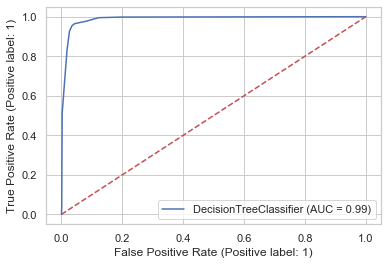

In [107]:
plot_roc_curve(estimator=tuned_mod,X= xtest_bal,y= ytest_bal)
plt.plot([0,1],[0,1],'r--')
plt.show()

In [105]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(xtrain_bal),
    feature_names=xtrain_bal.columns,
    mode='classification'
)


lime_exp = lime_explainer.explain_instance(
    data_row=xtest_bal.iloc[1],
    predict_fn=tuned_mod.predict_proba
)
lime_exp.show_in_notebook(show_table=True)

### Random Forest (Bagging)

In [126]:
rf = RandomForestClassifier(n_estimators=250)

In [129]:
params = {'max_depth':np.arange(30,50,5)}

In [130]:
rf_grid = GridSearchCV(estimator=rf,param_grid=params,cv=5,n_jobs=-1)
rf_grid.fit(xtrain_bal,ytrain_bal)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=250),
             n_jobs=-1, param_grid={'max_depth': array([30, 35, 40, 45])})

In [131]:
rf_grid.best_params_

{'max_depth': 30}

In [132]:
rf_tuned = RandomForestClassifier(n_estimators=250,max_depth=30).fit(xtrain_bal,ytrain_bal)

In [135]:
print('Random Forest:')
ypred = rf_tuned.predict(xtest_bal)
print(classification_report(ytest_bal,ypred))
print("Cohen Kappa Score:",round(cohen_kappa_score(ypred,ytest_bal),3))

Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      6868
           1       0.95      0.98      0.97      6372

    accuracy                           0.97     13240
   macro avg       0.97      0.97      0.97     13240
weighted avg       0.97      0.97      0.97     13240

Cohen Kappa Score: 0.936


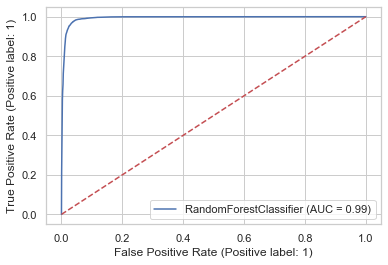

In [134]:
plot_roc_curve(estimator=rf_tuned, X = xtest_bal, y = ytest_bal)
plt.plot([0,1],[0,1],'r--')

## Boosting 

### 1.Adaboost

In [136]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=50)

In [137]:
adaboost.fit(xtrain_bal,ytrain_bal)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [140]:
ypred_prob = adaboost.predict_proba(xtest_bal)[:,1]

In [148]:
ypred = adaboost.predict(xtest_bal)


In [149]:
print('Adaboost:')
print(classification_report(ytest_bal,ypred))
print('Cohen Kappa Score:',round(cohen_kappa_score(ytest_bal,ypred),2))

Adaboost:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      6868
           1       0.94      0.93      0.94      6372

    accuracy                           0.94     13240
   macro avg       0.94      0.94      0.94     13240
weighted avg       0.94      0.94      0.94     13240

Cohen Kappa Score: 0.88


In [150]:
fpr,tpr,th = roc_curve(ytest_bal,ypred_prob)

In [151]:
plot_roc_curve(estimator=adaboost,X=xtest_bal,y=ytest_bal)
plt.plot([0,1],[0,1],'r--')
plt.show()

## XG Boost

In [152]:
xgb = XGBClassifier(gamma=1)

In [156]:
xgb.fit(xtrain_bal,ytrain_bal)

[15:12:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [157]:
ypred =xgb.predict(xtest_bal)
ypred_prob = xgb.predict_proba(xtest_bal)[:,1]

In [159]:
print('XG Boost')
print(classification_report(ytest_bal,ypred))
print('COhen Kappa Score:',round(cohen_kappa_score(ytest_bal,ypred),2))

XG Boost
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6868
           1       0.97      0.95      0.96      6372

    accuracy                           0.96     13240
   macro avg       0.96      0.96      0.96     13240
weighted avg       0.96      0.96      0.96     13240

COhen Kappa Score: 0.92


In [160]:
fpr,tpr,th = roc_curve(ytest_bal,ypred_prob)

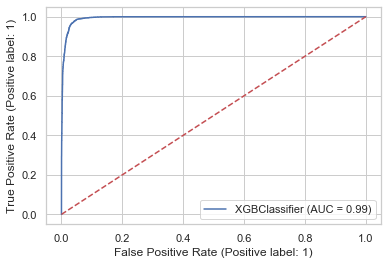

In [161]:
plot_roc_curve(estimator=xgb,X=xtest_bal,y=ytest_bal)
plt.plot([0,1],[0,1],'r--')
plt.show()

## Stacking

In [163]:
base = [('dt',DecisionTreeClassifier()),('rf',RandomForestClassifier())]
stack_mod = StackingClassifier(estimators=base,final_estimator=AdaBoostClassifier())
stack_mod.fit(xtrain_bal,ytrain_bal)

StackingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                               ('rf', RandomForestClassifier())],
                   final_estimator=AdaBoostClassifier())

In [164]:
ypred = stack_mod.predict(xtest_bal)

In [165]:
print('Stacking:')
print(classification_report(ytest_bal,ypred))
print('Cohen Kappa Score',round(cohen_kappa_score(ytest_bal,ypred),2))

Stacking:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6868
           1       0.96      0.98      0.97      6372

    accuracy                           0.97     13240
   macro avg       0.97      0.97      0.97     13240
weighted avg       0.97      0.97      0.97     13240

Cohen Kappa Score 0.94


In [166]:
plot_roc_curve(estimator=stack_mod,X=xtest_bal,y=ytest_bal)
plt.plot([0,1],[0,1],'r--')

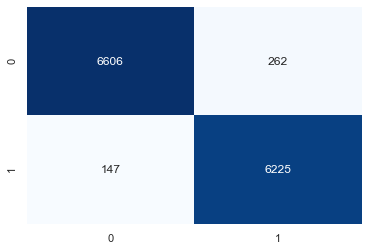

In [167]:
sns.heatmap(confusion_matrix(ytest_bal,ypred),annot=True,fmt='d',cbar=False,cmap='Blues')

## KNN Model

In [170]:
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier

In [171]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain_bal,ytrain_bal)

KNeighborsClassifier()

In [172]:
knn_pred = knn.predict(xtest_bal)

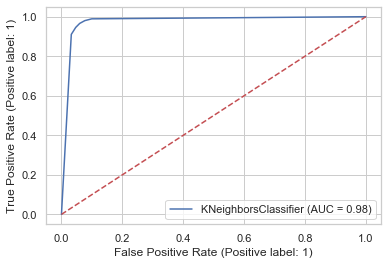

In [174]:
plot_roc_curve(estimator=knn,X=xtest_bal,y=ytest_bal)
plt.plot([0,1],[0,1],'r--')
plt.show()

In [176]:
rnn = RadiusNeighborsClassifier(radius=3)
rnn.fit(xtrain_bal,ytrain_bal)

RadiusNeighborsClassifier(radius=3)

In [177]:
rnn_pred = rnn.predict(xtest_bal)

In [179]:
print('KNN Classifier:')
print(classification_report(ytest_bal,rnn_pred))
print('Cohen Kappa Score',round(cohen_kappa_score(ytest_bal,rnn_pred),3))

KNN Classifier:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      6868
           1       0.92      0.93      0.92      6372

    accuracy                           0.92     13240
   macro avg       0.92      0.92      0.92     13240
weighted avg       0.92      0.92      0.92     13240

Cohen Kappa Score 0.85


In [ ]:
plot_roc_curve(estimator=rnn
               ,X=xtest_bal,y=ytest_bal)
plt.plot([0,1],[0,1],'r--')
plt.show()


KeyboardInterrupt



## Naive Bayes 

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()
gnb.fit(xtrain,ytrain)
gnb_pred = gnb.predict(xtest)

In [ ]:
plot_roc_curve(estimator=gnb,X=xtest,y=ytest)
plt.plot([0,1],[0,1],'r--')
plt.show()

In [ ]:
print('Naive Bayes Classifier:')
print(classification_report(ytest,gnb_pred))
print('Cohen Kappa Score',round(cohen_kappa_score(ytest,gnb_pred),2))
print('ROC AUC Score: 0.93')

* As we can see the AUC-ROC score of Random Forest is highest than other models. Hence we can use RandomForest as our final model.

Lime